# Implementation Parameter Tuning on Titanic

## Purpose
- To understand parameter tuning with cross validation
    - There're no explanations about data structure, feature engineering and kfold.

## Reference
- [3.1. Cross-validation: evaluating estimator performance — scikit-learn 0.21.2 documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance)

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

%matplotlib inline

# Data Preparation
There's not feature engineering because this notebook's purpose is to learn how to implement simple parameter tuning.

If you want to know feature engineering, you can find it in other great kernels.

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submit_data = pd.read_csv('../input/gender_submission.csv')

## Data Cleaning

In [3]:
train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

train['Age'] = train['Age'].fillna(train['Age'].median())
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0})
train['Embarked'] = train['Embarked'].fillna('S')

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [4]:
test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

test['Age'] = test['Age'].fillna(test['Age'].median())
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,Q
1,3,0,47.0,1,0,7.0000,S
2,2,1,62.0,0,0,9.6875,Q
3,3,1,27.0,0,0,8.6625,S
4,3,0,22.0,1,1,12.2875,S


In [5]:
# FYI: I prefer to use this coding rule just like sklearn.
X = pd.get_dummies(train.drop(columns=['Survived']), drop_first=True)
y = train['Survived']

X_test = pd.get_dummies(test, drop_first=True)

## Training baseline svc model

In [6]:
clf = SVC(random_state=0).fit(X, y)

print(f'Training accuracy: {clf.score(X, y):.5f}')

Training accuracy: 0.88328


## Making Submissoin Data

In [7]:
# Public Score: 0.61722
# It's a big difference between training accuracy and public score.
submit_data['Survived'] = clf.predict(X_test)
submit_data.to_csv('svc01_baseline.csv', index=False)

# Parameter Tuning
Each paramters explanation are [here: sklearn.svm.SVC — scikit-learn 0.21.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [8]:
# Use this kfold through this notebook.
kf = KFold(n_splits=5, random_state=0, shuffle=True)

## Single parameter search "C"

### Paramter Search

In [9]:
C_list = [1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3]

best_score = 0
best_C = C_list[0]

train_scores = []
valid_scores = []

for C in C_list:
    print(f'C: {C}')
    train_acc_list = []
    valid_acc_list = []

    for idx, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]

        y_train = y[train_index] # y's dtype is pd.Series
        y_valid = y[valid_index]

        clf = SVC(C=C, random_state=0).fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        valid_acc = clf.score(X_valid, y_valid)
        print(f'\tCV{idx}: Train: {train_acc:.3f} / Valid: {valid_acc:.3f}')

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    cv_train_score = np.mean(train_acc_list)
    cv_valid_score = np.mean(valid_acc_list)

    train_scores.append(cv_train_score)
    valid_scores.append(cv_valid_score)

    if cv_valid_score > best_score:
        best_score = cv_valid_score
        best_C = C

C: 0.01
	CV1: Train: 0.617 / Valid: 0.615
	CV2: Train: 0.614 / Valid: 0.624
	CV3: Train: 0.602 / Valid: 0.674
	CV4: Train: 0.614 / Valid: 0.624
	CV5: Train: 0.634 / Valid: 0.545
C: 0.1
	CV1: Train: 0.617 / Valid: 0.615
	CV2: Train: 0.614 / Valid: 0.624
	CV3: Train: 0.602 / Valid: 0.674
	CV4: Train: 0.614 / Valid: 0.624
	CV5: Train: 0.634 / Valid: 0.545
C: 1.0
	CV1: Train: 0.886 / Valid: 0.698
	CV2: Train: 0.903 / Valid: 0.674
	CV3: Train: 0.886 / Valid: 0.713
	CV4: Train: 0.888 / Valid: 0.713
	CV5: Train: 0.885 / Valid: 0.612
C: 10.0
	CV1: Train: 0.938 / Valid: 0.726
	CV2: Train: 0.957 / Valid: 0.680
	CV3: Train: 0.942 / Valid: 0.719
	CV4: Train: 0.952 / Valid: 0.713
	CV5: Train: 0.948 / Valid: 0.736
C: 100.0
	CV1: Train: 0.961 / Valid: 0.715
	CV2: Train: 0.975 / Valid: 0.669
	CV3: Train: 0.965 / Valid: 0.713
	CV4: Train: 0.971 / Valid: 0.697
	CV5: Train: 0.962 / Valid: 0.719
C: 1000.0
	CV1: Train: 0.965 / Valid: 0.665
	CV2: Train: 0.976 / Valid: 0.674
	CV3: Train: 0.966 / Valid: 0.742

In [10]:
print(f'Best valid accuracy: {best_score:.5f} (C={best_C})')

Best valid accuracy: 0.71491 (C=10.0)


### Visualization

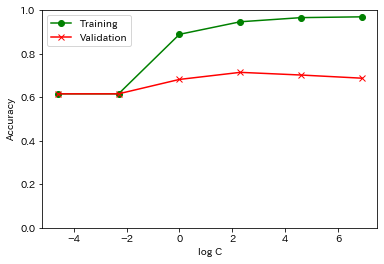

In [11]:
plt.plot(np.log(C_list), train_scores, color='green', marker='o', label='Training')
plt.plot(np.log(C_list), valid_scores, color='red', marker='x', label='Validation')

plt.ylim(0, 1)

plt.xlabel('log C')
plt.ylabel('Accuracy')

plt.legend()

### Retraining

In [12]:
best_clf = SVC(C=best_C, random_state=0).fit(X, y)

# Public Score: 0.61722 -> 0.65071
# The score gap become smaller than basline model.
submit_data['Survived'] = best_clf.predict(X_test)
submit_data.to_csv('svc02_best_C.csv', index=False)

## gamma

### Single Paramter Search "gamma"

In [13]:
gamma_list = [1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3]

best_score = 0
best_gamma = gamma_list[0]

train_scores =  []
valid_scores =  []

for gamma in gamma_list:
    print(f'gamma: {gamma}')
    train_acc_list = []
    valid_acc_list = []

    for idx, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]

        y_train = y[train_index]
        y_valid = y[valid_index]

        clf = SVC(gamma=gamma, random_state=0).fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        valid_acc = clf.score(X_valid, y_valid)
        print(f'\tCV{idx}: Train: {train_acc:.3f} / Valid: {valid_acc:.3f}')

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    # CVごとの平均
    cv_train_score = np.mean(train_acc_list)
    cv_valid_score = np.mean(valid_acc_list)
    
    train_scores.append(cv_train_score)
    valid_scores.append(cv_valid_score)
    
    if cv_valid_score  > best_score:
        best_score  = cv_valid_score
        best_gamma = gamma

gamma: 0.01
	CV1: Train: 0.747 / Valid: 0.743
	CV2: Train: 0.767 / Valid: 0.652
	CV3: Train: 0.743 / Valid: 0.708
	CV4: Train: 0.763 / Valid: 0.725
	CV5: Train: 0.757 / Valid: 0.657
gamma: 0.1
	CV1: Train: 0.879 / Valid: 0.709
	CV2: Train: 0.889 / Valid: 0.674
	CV3: Train: 0.870 / Valid: 0.697
	CV4: Train: 0.884 / Valid: 0.719
	CV5: Train: 0.875 / Valid: 0.624
gamma: 1.0
	CV1: Train: 0.956 / Valid: 0.682
	CV2: Train: 0.972 / Valid: 0.663
	CV3: Train: 0.959 / Valid: 0.753
	CV4: Train: 0.966 / Valid: 0.635
	CV5: Train: 0.964 / Valid: 0.624
gamma: 10.0
	CV1: Train: 0.966 / Valid: 0.642
	CV2: Train: 0.976 / Valid: 0.669
	CV3: Train: 0.966 / Valid: 0.702
	CV4: Train: 0.976 / Valid: 0.618
	CV5: Train: 0.971 / Valid: 0.601
gamma: 100.0
	CV1: Train: 0.978 / Valid: 0.637
	CV2: Train: 0.980 / Valid: 0.680
	CV3: Train: 0.975 / Valid: 0.708
	CV4: Train: 0.979 / Valid: 0.629
	CV5: Train: 0.979 / Valid: 0.601
gamma: 1000.0
	CV1: Train: 0.979 / Valid: 0.637
	CV2: Train: 0.983 / Valid: 0.669
	CV3: Tra

In [14]:
print(f'Best valid accuracy: {best_score:.5f} (gamma={best_gamma})')

Best valid accuracy: 0.69692 (gamma=0.01)


### Visualization

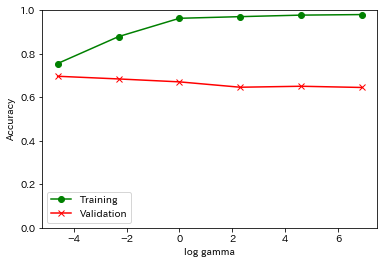

In [15]:
plt.plot(np.log(gamma_list), train_scores, color='green', marker='o', label='Training')
plt.plot(np.log(gamma_list), valid_scores, color='red', marker='x', label='Validation')

plt.ylim(0, 1)
plt.xlabel('log gamma')
plt.ylabel('Accuracy')

plt.legend()

### Retraining

In [16]:
best_clf = SVC(C=best_C, random_state=0).fit(X, y)

# Public Score: 0.65071
submit_data['Survived'] = best_clf.predict(X_test)
submit_data.to_csv('svc03_best_gamma.csv', index=False)

## Multi parameters search without libraries (except for KFold)

### Paramter Search

In [17]:
best_score = 0
best_params = {'C': C_list[0], 'gamma': gamma_list[0], 'random_state': 0}

train_scores =  []
valid_scores =  []

# To use visualizing heatmap
params_C = []
params_gamma = []

for C in C_list:
    for gamma in gamma_list:
        train_acc_list = []
        valid_acc_list = []

        for train_index, valid_index in kf.split(X, y):
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]

            y_train = y[train_index]
            y_valid = y[valid_index]

            clf = SVC(C=C, gamma=gamma, random_state=0).fit(X_train, y_train)

            train_acc_list.append(clf.score(X_train, y_train))
            valid_acc_list.append(clf.score(X_valid, y_valid))
            
        params_C.append(C)
        params_gamma.append(gamma)

        cv_train_score = np.mean(train_acc_list)
        cv_valid_score = np.mean(valid_acc_list)

        train_scores.append(cv_train_score)
        valid_scores.append(cv_valid_score)

        if cv_valid_score > best_score:
            best_score  = cv_valid_score
            best_params = {'C': C, 'gamma': gamma, 'random_state': 0}

In [18]:
print(f'Best valid accuracy: {best_score:.5f} ({best_params})')

Best valid accuracy: 0.76543 ({'C': 100.0, 'gamma': 0.01, 'random_state': 0})


### Visualization(Heatmap)

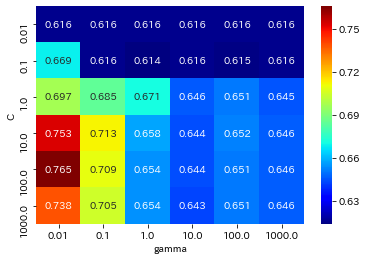

In [19]:
df = pd.DataFrame()
df['C'] = params_C
df['gamma'] = params_gamma
df['train_score']= train_scores
df['valid_score']= valid_scores

pivot = df.pivot(index='C', columns='gamma', values='valid_score')

sns.heatmap(data=pivot,
            annot=True,
            fmt='.3f',
            cmap='jet')

### Retraining

In [20]:
best_clf = SVC(**best_params).fit(X, y)

# Public Score: 0.69856
submit_data['Survived'] = best_clf.predict(X_test)
submit_data.to_csv('svc04_manual_parameter_search.csv', index=False)

## Multi paramters search using sklearn.model_selection.ParameterGrid

### Simple Usage

In [21]:
param_grid = {'C': C_list,
              'gamma': gamma_list,
              'random_state': [0]}

for params in ParameterGrid(param_grid):
    print(params)

{'C': 0.01, 'gamma': 0.01, 'random_state': 0}
{'C': 0.01, 'gamma': 0.1, 'random_state': 0}
{'C': 0.01, 'gamma': 1.0, 'random_state': 0}
{'C': 0.01, 'gamma': 10.0, 'random_state': 0}
{'C': 0.01, 'gamma': 100.0, 'random_state': 0}
{'C': 0.01, 'gamma': 1000.0, 'random_state': 0}
{'C': 0.1, 'gamma': 0.01, 'random_state': 0}
{'C': 0.1, 'gamma': 0.1, 'random_state': 0}
{'C': 0.1, 'gamma': 1.0, 'random_state': 0}
{'C': 0.1, 'gamma': 10.0, 'random_state': 0}
{'C': 0.1, 'gamma': 100.0, 'random_state': 0}
{'C': 0.1, 'gamma': 1000.0, 'random_state': 0}
{'C': 1.0, 'gamma': 0.01, 'random_state': 0}
{'C': 1.0, 'gamma': 0.1, 'random_state': 0}
{'C': 1.0, 'gamma': 1.0, 'random_state': 0}
{'C': 1.0, 'gamma': 10.0, 'random_state': 0}
{'C': 1.0, 'gamma': 100.0, 'random_state': 0}
{'C': 1.0, 'gamma': 1000.0, 'random_state': 0}
{'C': 10.0, 'gamma': 0.01, 'random_state': 0}
{'C': 10.0, 'gamma': 0.1, 'random_state': 0}
{'C': 10.0, 'gamma': 1.0, 'random_state': 0}
{'C': 10.0, 'gamma': 10.0, 'random_state': 0}

### Paramter Search

In [22]:
train_scores = []
valid_scores = []

best_score = 0
best_params = {'C': C_list[0],
               'gamma': gamma_list[0],
               'random_state': 0}

# To use visualizing heatmap
params_C = []
params_gamma = []

for params in ParameterGrid(param_grid):
    train_acc_list = []
    valid_acc_list = []

    for train_index, valid_index in kf.split(X, y):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]

        y_train = y[train_index]
        y_valid = y[valid_index]

        clf = SVC(**params).fit(X_train, y_train)

        train_acc_list.append(clf.score(X_train, y_train))
        valid_acc_list.append(clf.score(X_valid, y_valid))

    params_C.append(params['C'])
    params_gamma.append(params['gamma'])

    cv_train_score = np.mean(train_acc_list)
    cv_valid_score = np.mean(valid_acc_list)

    train_scores.append(cv_train_score)
    valid_scores.append(cv_valid_score)

    if cv_valid_score > best_score:
        best_score = cv_valid_score
        best_params = params

In [23]:
print(f'Best valid accuracy: {best_score:.5f} ({best_params})')

Best valid accuracy: 0.76543 ({'C': 100.0, 'gamma': 0.01, 'random_state': 0})


### Visualization(Heatmap)

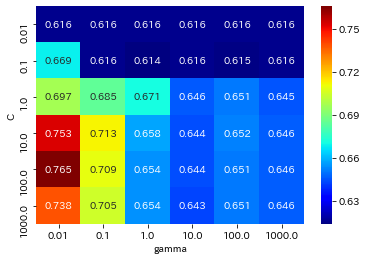

In [24]:
df = pd.DataFrame()
df['C'] = params_C
df['gamma'] = params_gamma
df['train_score']= train_scores
df['valid_score']= valid_scores

pivot = df.pivot(index='C', columns='gamma', values='valid_score')

sns.heatmap(data=pivot,
            annot=True,
            fmt='.3f',
            cmap='jet')

### Retraining

In [25]:
best_clf = SVC(**best_params).fit(X, y)

# Public Score: 0.69856
submit_data['Survived'] = best_clf.predict(X_test)
submit_data.to_csv('svc05_sklearn_parameter_grid.csv', index=False)

## Multi paramters search using sklearn.model_selection.GridSearchCV
GridSearchCV is so powerful. But the processing flow is not easy to understand very.

Actually, I didn't understand the flow when I first use GridSearchCV(especially about retraining).

Though you might not me, I recommend you to implement without libraries.

[The sklearn document](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) is very helpful to see the flow.

In [26]:
gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=kf)

gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'gamma': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [27]:
print(f'Best valid accuracy: {gs.best_score_:.5f} ({gs.best_params_})')

Best valid accuracy: 0.73913 ({'C': 100.0, 'gamma': 0.01, 'random_state': 0})


In [28]:
# You don't need to retrain!
# 'gs' automatically selects `gs.best_estimator_` that is already retrained on training data with best paramters.

# Public Score: 0.69856
submit_data['Survived'] = gs.predict(X_test)
submit_data.to_csv('svc06_sklearn_grid_search_cv.csv', index=False)